In [18]:
import numpy as np
import scipy 
import itertools as it

from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, assemble

In [2]:
def Heatsquare(B1=1, B2=1, deg=1, N=3):
    h1, h2 = 1/B1, 1/B2
    geos= [geometry.unit_square().scale((h1,h2)).translate((j*h1,i*h2)) for i,j in it.product(range(B2),range(B1))]
    kvs = B1*B2 *[2* (bspline.make_knots(deg,0,1,N),)]
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches, domains={i:{i} for i in range(B1*B2)})
    M.set_boundary_id({'D':{(B1*B2 - i - 1,1) for i in range(B1)},'N0':{(B1*j,2) for j in range(B2)}|{(B1*j+B1-1,3) for j in range(B2)},'N1':{(i,0) for i in range(B1)}})
    return M

In [5]:
B1,B2 = 5,5
M = Heatsquare(B1,B2,1,10)

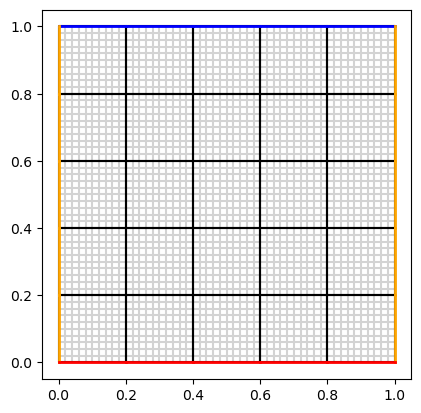

In [6]:
M.draw(knots=1,patch_idx=0, bcolor={'D':'blue','N0':'orange','N1':'red'},bwidth=2)

In [7]:
f = lambda x,y: 0.
g = lambda x,y: 0.
n = lambda x,y: 1.

V = vform.VForm(2)
u, v = V.basisfuns()
B = V.let('B', V.W * vform.dot(V.JacInv, V.JacInv.T), symmetric=True)
coeff = V.parameter('coeff')
V.add(coeff*B.dot(vform.grad(u, parametric=True)).dot(vform.grad(v, parametric=True)))

MP = assemble.Multipatch(M, automatch=True)
A = [MP.assemble_volume(V, coeff = 1, domain_id=k) for k in range(B1*B2)]
F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f)
dir_bcs = MP.compute_dirichlet_bcs({'D':g})
Ne = MP.assemble_surface('(n * v) * ds', arity=1, n=n, boundary_idx='N1')
rhs = F + Ne

mu_min = 0.5
mu_max = 2
N = 5
Phi = np.zeros((MP.numdofs,N))

for j in range(N):
    #mu = np.random.rand()*(mu_max-mu_min) + mu_min
    mu = j/(N-1)*(mu_max-mu_min) + mu_min
    A_ = MP.assemble_volume(V, coeff =mu, domain_id=0) 
    LS = assemble.RestrictedLinearSystem(A_+sum(A[1:]), rhs, dir_bcs)
    Phi[:,j] = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

setting up constraints took 0.11610221862792969 seconds.
Basis setup took 0.0539393424987793 seconds


In [8]:
Phi,R = np.linalg.qr(Phi)

In [9]:
A_Nq = np.array([Phi.T@A@Phi for A in A])
def A_N(mu):
    return mu * A_Nq[0] + sum(A_Nq[1:])

In [10]:
mu = np.random.rand()*(mu_max-mu_min)+mu_min
#mu=2
u = Phi@np.linalg.solve(A_N(mu),Phi.T@rhs)

In [11]:
A_ = MP.assemble_volume(V, coeff = mu, domain_id=0) + sum(A[1:])
LS = assemble.RestrictedLinearSystem(A_, rhs, dir_bcs)
u_exact = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

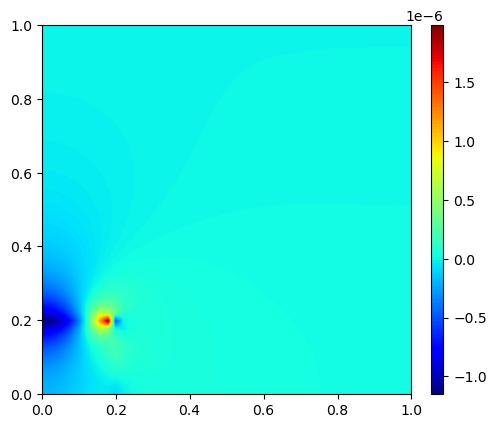

In [12]:
MP.plot(u-u_exact, cmap='jet')

In [13]:
np.sqrt((u-u_exact)@A_@(u-u_exact))

3.2723970577180815e-06

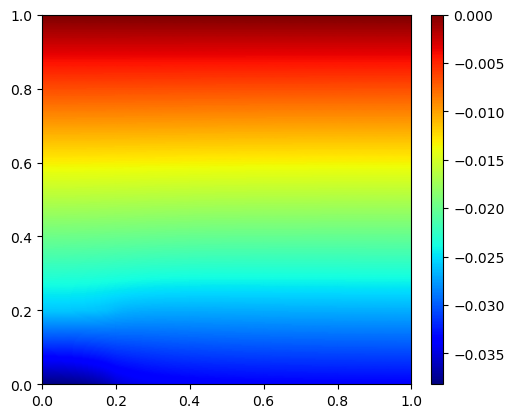

In [17]:
MP.plot(Phi[:,0], cmap='jet')

In [19]:
V = vform.VForm(2)
u, v = V.basisfuns()
B = V.let('B', V.W * vform.dot(V.JacInv, V.JacInv.T), symmetric=True)
coeff = V.parameter('coeff')
V.add(coeff*B.dot(vform.grad(u, parametric=True)).dot(vform.grad(v, parametric=True)))

In [37]:
vform.stiffness_vf(2)

In [21]:
V